In [12]:
import pandas as pd
import numpy as np
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt

# import seaborn as sns
# import seaborn.objects as so

# # extension patch by intel to speed up sklearn
# from sklearnex import patch_sklearn
# patch_sklearn()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation
from scipy import stats


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


# init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
# configure pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 450)
pd.set_option('display.max_columns', 150)

In [13]:
mac = 0

In [14]:
if mac:
    dpath = '/Users/cglab/projects/abcd/data/abcd5.1-rser/'
else:
    dpath = '/home/cglab/projects/abcd/data/abcd5.1-rser/'

In [15]:
rs = pd.read_csv(dpath + 'abcd5.1_rsfmri_cor_insula_subc_net_ders_gses_sfam_thrt_demo_noscl_nopt_wide_qc_lfa.csv', low_memory=False)

In [17]:
rs[['scanID', 'scanID_yr2', 'Threat', 'ThreatCB', 'Aware']].corr()

,scanID,scanID_yr2,Threat,ThreatCB,Aware
scanID,1.000000,0.838404,-0.010633,-0.009008,-0.023135
scanID_yr2,0.838404,1.000000,-0.010508,-0.006195,-0.005514
Threat,-0.010633,-0.010508,1.000000,0.779530,0.137720
ThreatCB,-0.009008,-0.006195,0.779530,1.000000,0.110855
Aware,-0.023135,-0.005514,0.137720,0.110855,1.000000


### Split data for Training/Validation and Test
* rs_train_val will be split further during 5fold cross validation 

In [5]:
# split off 20% of data, that the model is **not** trained or validated on, for the final test
rs_train_val, rs_test = train_test_split(rs, train_size = 0.8, random_state=9977)
print('Set Sizes:\n  Training & Validation: {0}\n  Testing: {1}'.format(rs_train_val.shape[0], rs_test.shape[0]))

Set Sizes:
  Training & Validation: 4603
  Testing: 1151


In [6]:
rs.columns.tolist()

['Aware',
 'NoAcpt',
 'Implse',
 'Goals',
 'Threat',
 'subID',
 'ThreatSQ',
 'ThreatCB',
 'eventname_yr2',
 'rsfmri_var_cdk_insulalh_yr2',
 'rsfmri_var_cdk_insularh_yr2',
 'rsfmri_var_cdk_rlaclatelh_yr2',
 'rsfmri_var_cdk_rlaclaterh_yr2',
 'rsfmri_var_cdk_entorhinallh_yr2',
 'rsfmri_var_cdk_entorhinalrh_yr2',
 'rsfmri_var_scs_amygdalalh_yr2',
 'rsfmri_var_scs_amygdalarh_yr2',
 'rsfmri_var_scs_hpuslh_yr2',
 'rsfmri_var_scs_hpusrh_yr2',
 'rsfmri_var_scs_putamenlh_yr2',
 'rsfmri_var_scs_putamenrh_yr2',
 'rsfmri_var_scs_tplh_yr2',
 'rsfmri_var_scs_tprh_yr2',
 'rsfmri_var_scs_ventraldclh_yr2',
 'rsfmri_var_scs_ventraldcrh_yr2',
 'rsfmri_var_scs_aalh_yr2',
 'rsfmri_var_scs_aarh_yr2',
 'mrirsfd121_yr2',
 'mrirsfd48_yr2',
 'mrirsfd122_yr2',
 'mrirsfd49_yr2',
 'mrirsfd123_yr2',
 'mrirsfd47_yr2',
 'sa_scs_aalh_yr2',
 'sa_scs_aarh_yr2',
 'sa_scs_aglh_yr2',
 'sa_scs_agrh_yr2',
 'sa_scs_bs_yr2',
 'sa_scs_cdelh_yr2',
 'sa_scs_cderh_yr2',
 'sa_scs_crcxlh_yr2',
 'sa_scs_crcxrh_yr2',
 'sa_scs_hplh_yr2'

In [7]:
ses = [c for c in rs.columns if 'ses' in c or 'SES' in c or 'latent_factor' in c]
bio = [c for c in rs.columns if 'var' in c or 'ngd' in c or 'scs' in c or 'mri' in c]
ses

['latent_factor_ss_general_ses_yr2',
 'latent_factor_ss_social_yr2',
 'latent_factor_ss_perinatal_yr2',
 'SES',
 'latent_factor_ss_social_yr1',
 'latent_factor_ss_perinatal_yr1']

In [8]:
rs[ses + ['income']].isnull().sum()

latent_factor_ss_general_ses_yr2    5754
latent_factor_ss_social_yr2         5754
latent_factor_ss_perinatal_yr2      5754
SES                                 1449
latent_factor_ss_social_yr1         1449
latent_factor_ss_perinatal_yr1      1449
income                               418
dtype: int64

In [11]:
rs[['sa_ngd_vta_yr1', 'sa_ngd_vta_yr2', 'Threat', 'ThreatSQ', 'ThreatCB', 'Aware']].corr()

,sa_ngd_vta_yr1,sa_ngd_vta_yr2,Threat,ThreatSQ,ThreatCB,Aware
sa_ngd_vta_yr1,1.000000,0.450424,-0.003217,-0.004507,-0.005189,0.030866
sa_ngd_vta_yr2,0.450424,1.000000,-0.010642,-0.022302,-0.025053,0.046574
Threat,-0.003217,-0.010642,1.000000,0.496863,0.779530,0.137720
ThreatSQ,-0.004507,-0.022302,0.496863,1.000000,0.836516,0.080067
ThreatCB,-0.005189,-0.025053,0.779530,0.836516,1.000000,0.110855
Aware,0.030866,0.046574,0.137720,0.080067,0.110855,1.000000


#### Impute Missing Ders 
* separately from other predictor varialbes

In [9]:
# Impute
dersnm = ['Aware', 'NoAcpt', 'Implse', 'Goals']
impa = IterativeImputer(max_iter=20, random_state=0)
ders_imp = impa.fit_transform(rs[dersnm])
dersf = pd.DataFrame(ders_imp, columns=dersnm)
print(dersf.shape)
dersf.isnull().any()

(5754, 4)


Aware     False
NoAcpt    False
Implse    False
Goals     False
dtype: bool

In [10]:
dersf.shape, rs['subID'].shape

((5754, 4), (5754,))

In [11]:
dersf.tail(40)

,Aware,NoAcpt,Implse,Goals
5714,-2.080522e-01,-5.146364e-01,-6.045242e-02,-2.715154e-01
5715,-1.972741e-01,-1.073126e-01,-6.193713e-01,-1.016103e+00
5716,-1.124236e+00,3.015888e+00,2.861379e+00,2.397986e+00
5717,-1.114075e+00,-3.583217e-01,-6.022638e-01,-5.199425e-01
5718,-1.794129e-01,-1.866217e-01,-6.356467e-01,-1.169663e+00
5719,1.089350e+00,-4.609326e-01,1.702019e-02,1.440354e+00
5720,-2.401931e-01,-3.176352e-01,-3.681790e-01,-4.795447e-01
5721,-7.210465e-01,4.168467e-01,-2.420301e-01,-2.591242e-01
5722,-2.666915e-01,1.086124e-01,-5.503862e-01,-3.048845e-01
5723,-2.169577e-01,3.961142e-01,6.242137e-01,1.435010e-01


##### append subID to imputed ders df
* for merging below

In [12]:
dersf = pd.concat([dersf, rs['subID']], axis=1)
print(dersf)
dersf.tail()

             Aware        NoAcpt        Implse         Goals             subID
0     1.725059e+00 -4.523538e-01  8.656765e-01  5.303338e-01  NDAR_INV00CY2MDM
1    -2.210190e-01  4.201087e-01  4.164593e-01  1.237769e-01  NDAR_INV00HEV6HB
2     3.701929e-01  1.102345e+00  1.319362e+00  1.807149e+00  NDAR_INV00U4FTRU
3    -1.216133e+00 -4.708891e-01 -6.472988e-01 -9.718870e-01  NDAR_INV00X2TBWJ
4     4.000275e-01  6.627566e-02  1.943818e-01  1.530968e-02  NDAR_INV01AJ15N9
...            ...           ...           ...           ...               ...
5749 -1.161391e+00 -9.460915e-02 -4.159040e-02  1.110622e+00  NDAR_INVZZ81LEEV
5750  4.009570e-17 -4.020557e-19  2.782873e-18 -3.775852e-17  NDAR_INVZZLZCKAY
5751  4.362523e-02 -2.134398e-01  2.245913e-01  4.431216e-01  NDAR_INVZZNX6W2P
5752 -7.174280e-01 -2.162435e-03 -6.230346e-01 -1.017982e+00  NDAR_INVZZPKBDAC
5753  7.995541e-01  9.901103e-01  5.372273e-01  1.062416e+00  NDAR_INVZZZ2ALR6

[5754 rows x 5 columns]


,Aware,NoAcpt,Implse,Goals,subID
5749,-1.161391e+00,-9.460915e-02,-4.159040e-02,1.110622e+00,NDAR_INVZZ81LEEV
5750,4.009570e-17,-4.020557e-19,2.782873e-18,-3.775852e-17,NDAR_INVZZLZCKAY
5751,4.362523e-02,-2.134398e-01,2.245913e-01,4.431216e-01,NDAR_INVZZNX6W2P
5752,-7.174280e-01,-2.162435e-03,-6.230346e-01,-1.017982e+00,NDAR_INVZZPKBDAC
5753,7.995541e-01,9.901103e-01,5.372273e-01,1.062416e+00,NDAR_INVZZZ2ALR6


In [13]:
print(rs.shape)
print(dersf.shape)
set(rs.subID) - set(dersf.subID)

(5754, 339)
(5754, 5)


set()

##### Merge IMputed DErs df with rs df

In [14]:
# drop ders column with missing from rs
rs.drop(columns=dersnm, inplace=True)
# append ders columns withOUT missing to rs df
rs = rs.merge(dersf, how='left', on='subID')
rs.shape

(5754, 339)

#### Drop missing rows in MRI data

In [7]:
print(rs.shape)
rs.dropna(subset=bio, inplace=True)
print(rs.shape)
rs[bio].isnull().any()

(5754, 339)
(5732, 339)


rsfmri_var_cdk_insulalh_yr2        False
rsfmri_var_cdk_insularh_yr2        False
rsfmri_var_cdk_rlaclatelh_yr2      False
rsfmri_var_cdk_rlaclaterh_yr2      False
rsfmri_var_cdk_entorhinallh_yr2    False
rsfmri_var_cdk_entorhinalrh_yr2    False
rsfmri_var_scs_amygdalalh_yr2      False
rsfmri_var_scs_amygdalarh_yr2      False
rsfmri_var_scs_hpuslh_yr2          False
rsfmri_var_scs_hpusrh_yr2          False
rsfmri_var_scs_putamenlh_yr2       False
rsfmri_var_scs_putamenrh_yr2       False
rsfmri_var_scs_tplh_yr2            False
rsfmri_var_scs_tprh_yr2            False
rsfmri_var_scs_ventraldclh_yr2     False
rsfmri_var_scs_ventraldcrh_yr2     False
rsfmri_var_scs_aalh_yr2            False
rsfmri_var_scs_aarh_yr2            False
mrirsfd121_yr2                     False
mrirsfd48_yr2                      False
mrirsfd122_yr2                     False
mrirsfd49_yr2                      False
mrirsfd123_yr2                     False
mrirsfd47_yr2                      False
sa_scs_aalh_yr2 

In [8]:
rs.shape

(5732, 339)

### Random Forest
#### Specifiy predictor and target variables

In [9]:
rs.isnull().any()

Aware                                True
NoAcpt                               True
Implse                               True
Goals                                True
Threat                              False
subID                               False
ThreatSQ                            False
ThreatCB                            False
eventname_yr2                       False
rsfmri_var_cdk_insulalh_yr2         False
rsfmri_var_cdk_insularh_yr2         False
rsfmri_var_cdk_rlaclatelh_yr2       False
rsfmri_var_cdk_rlaclaterh_yr2       False
rsfmri_var_cdk_entorhinallh_yr2     False
rsfmri_var_cdk_entorhinalrh_yr2     False
rsfmri_var_scs_amygdalalh_yr2       False
rsfmri_var_scs_amygdalarh_yr2       False
rsfmri_var_scs_hpuslh_yr2           False
rsfmri_var_scs_hpusrh_yr2           False
rsfmri_var_scs_putamenlh_yr2        False
rsfmri_var_scs_putamenrh_yr2        False
rsfmri_var_scs_tplh_yr2             False
rsfmri_var_scs_tprh_yr2             False
rsfmri_var_scs_ventraldclh_yr2    

##### drop nan in ders

In [10]:
dersnm = ['Aware', 'NoAcpt', 'Implse', 'Goals']
rs.dropna(subset=dersnm, inplace=True)
rs.shape

(5181, 339)

#### predict Aware
* Ders Awareness latent factor summary score

In [19]:
# get cols that shouldn't go into Random Forest
cdrop = [c for c in rs.columns if 'newThrt' in c or 'ders' in c or 'Fcon' in c or 'FamCon' in c or 'school' in c]
# Not excluded currently: 'interview_age'
# cdrop += ['site_id_l_yr1', 'site_id_l_yr2']
cdrop += ['AwareER', 'Aware', 'Implse', 'Goals', 'NoAcpt', 'school_id_yr1', 'district_id_yr1', 'interview_age_yr1', 'visit_type_yr1'] # 'subID', 'eventname', 'eventname_yr1', 'eventname_yr2'
cdrop += ['latent_factor_ss_general_ses_yr2',
 'latent_factor_ss_social_yr2',
 'latent_factor_ss_perinatal_yr2']
rs_train, rs_val = train_test_split(rs, train_size = 0.9, random_state=9977)
# exclude all object type columns, object type in python is for string data
X_train = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1)

### Impute regular data (non-bio)

In [20]:
imp = IterativeImputer(max_iter=20, random_state=0)
X_train = imp.fit_transform(X_train)

In [21]:

# Y_train = rs_train['ders_awareness_score_3_year']
Y_train = rs_train['Aware']
print(X_train.shape)
print(Y_train.shape)

(5158, 180)
(5158,)


#### fit model

In [22]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

RandomForestRegressor()

#### predict unseen data

In [23]:
X_val = rs_val.select_dtypes(exclude=[object]).drop(cdrop, axis=1)
# impute validation X data
impv = IterativeImputer(max_iter=20, random_state=0)
X_val = impv.fit_transform(X_val)
Y_val = rs_val['Aware']
y_pred = rf.predict(X_val)

#### performance

In [24]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(Y_val, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(Y_val, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(Y_val, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(Y_val, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(Y_val, y_pred))
print('Max Error:', metrics.max_error(Y_val, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(Y_val, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(Y_val, y_pred))
print('R^2:', metrics.r2_score(Y_val, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(Y_val, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(Y_val, y_pred))

Mean Absolute Error (MAE): 0.6653609303368093
Mean Squared Error (MSE): 0.7190714076234317
Root Mean Squared Error (RMSE): 0.8479807825790816
Mean Absolute Percentage Error (MAPE): 60993070807512.28
Explained Variance Score: 0.008836378630296404
Max Error: 2.9658164704233623
Median Absolute Error: 0.5544646744822326
R^2: 0.008323376511519043


In [30]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(Y_val, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(Y_val, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(Y_val, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(Y_val, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(Y_val, y_pred))
print('Max Error:', metrics.max_error(Y_val, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(Y_val, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(Y_val, y_pred))
print('R^2:', metrics.r2_score(Y_val, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(Y_val, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(Y_val, y_pred))

Mean Absolute Error (MAE): 0.49370658314641774
Mean Squared Error (MSE): 0.49724781219062947
Root Mean Squared Error (RMSE): 0.7051580051241207
Mean Absolute Percentage Error (MAPE): 41371483789401.13
Explained Variance Score: 0.31435493680818005
Max Error: 2.6267634143730216
Median Absolute Error: 0.31013398542790926
R^2: 0.3142419150554342


#### Feature importances

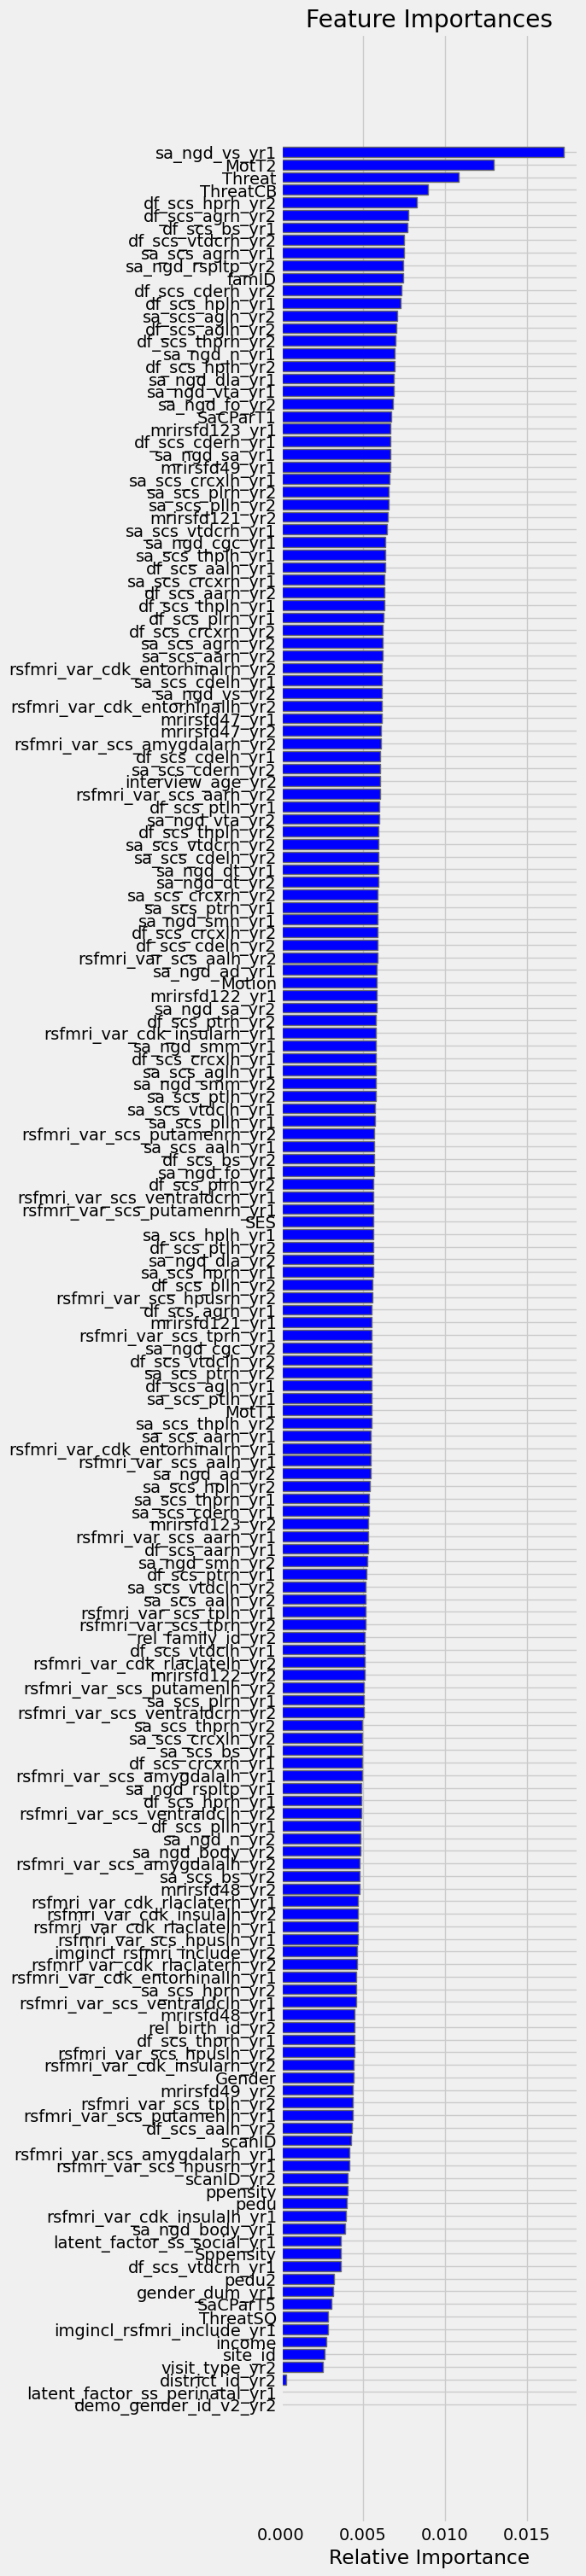

In [25]:
plt.figure(figsize=(4, 36))
features = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

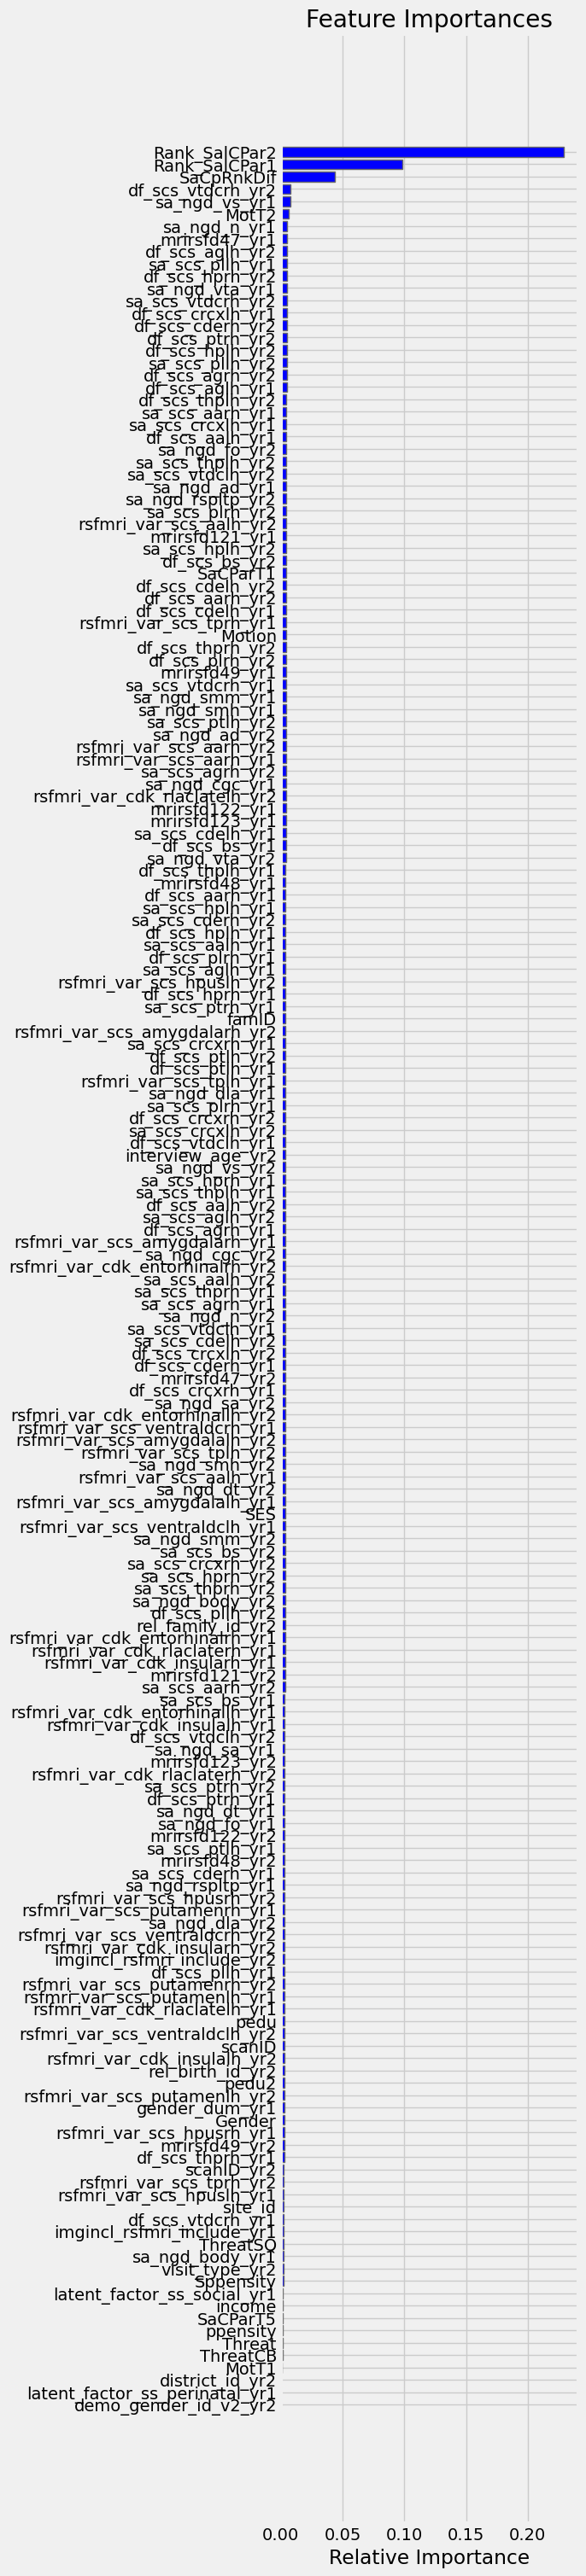

In [32]:
plt.figure(figsize=(4, 36))
features = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### predict Qaudratic Threat
* family threat  latent factor summary score squared

In [19]:
# get cols that shouldn't go into Random Forest
cdrop = [c for c in rs.columns if 'newThrt' in c or 'ders' in c or 'Fcon' in c or 'FamCon' in c or 'school' in c]
# Not excluded currently: 'interview_age'
# cdrop += ['site_id_l_yr1', 'site_id_l_yr2']
cdrop += ['Threat', 'ThreatSQ', 'ThreatCB', 'AwareER', 'Implse', 'Goals', 'NoAcpt', 'school_id_yr1', 'district_id_yr1', 'interview_age_yr1', 'visit_type_yr1'] # 'subID', 'eventname', 'eventname_yr1', 'eventname_yr2'
cdrop += ['latent_factor_ss_general_ses_yr2',
 'latent_factor_ss_social_yr2',
 'latent_factor_ss_perinatal_yr2']
rs_train, rs_val = train_test_split(rs, train_size = 0.9, random_state=9977)
# exclude all object type columns, object type in python is for string data
X_train = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1)

### Impute regular data (non-bio)

In [20]:
imp = IterativeImputer(max_iter=20, random_state=0)
X_train = imp.fit_transform(X_train)

In [26]:

# Y_train = rs_train['ders_awareness_score_3_year']
Y_train = rs_train['Threat']
print(X_train.shape)
print(Y_train.shape)

(4662, 178)
(4662,)


#### fit model

In [27]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

RandomForestRegressor()

#### predict unseen data

In [28]:
X_val = rs_val.select_dtypes(exclude=[object]).drop(cdrop, axis=1)
# impute validation X data
impv = IterativeImputer(max_iter=20, random_state=0)
X_val = impv.fit_transform(X_val)
Y_val = rs_val['Threat']
y_pred = rf.predict(X_val)

#### performance

In [29]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(Y_val, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(Y_val, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(Y_val, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(Y_val, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(Y_val, y_pred))
print('Max Error:', metrics.max_error(Y_val, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(Y_val, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(Y_val, y_pred))
print('R^2:', metrics.r2_score(Y_val, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(Y_val, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(Y_val, y_pred))

Mean Absolute Error (MAE): 0.5223591539857997
Mean Squared Error (MSE): 0.3907612615378817
Root Mean Squared Error (RMSE): 0.6251089997255532
Mean Absolute Percentage Error (MAPE): 1.1609157728239885
Explained Variance Score: 0.041036096075764195
Max Error: 1.7527173458682486
Median Absolute Error: 0.5446547780595203
R^2: 0.0315533967199596


In [24]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(Y_val, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(Y_val, y_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(Y_val, y_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(Y_val, y_pred))
print('Explained Variance Score:', metrics.explained_variance_score(Y_val, y_pred))
print('Max Error:', metrics.max_error(Y_val, y_pred))
# print('Mean Squared Log Error:', metrics.mean_squared_log_error(Y_val, y_pred))
print('Median Absolute Error:', metrics.median_absolute_error(Y_val, y_pred))
print('R^2:', metrics.r2_score(Y_val, y_pred))
# print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(Y_val, y_pred))
# print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(Y_val, y_pred))

Mean Absolute Error (MAE): 0.3522387108786847
Mean Squared Error (MSE): 0.25377958779315174
Root Mean Squared Error (RMSE): 0.5037654094845653
Mean Absolute Percentage Error (MAPE): 17.372260150318617
Explained Variance Score: -0.008720014417049171
Max Error: 2.826547379303204
Median Absolute Error: 0.2790491321334922
R^2: -0.018116851799588662


#### Feature importances

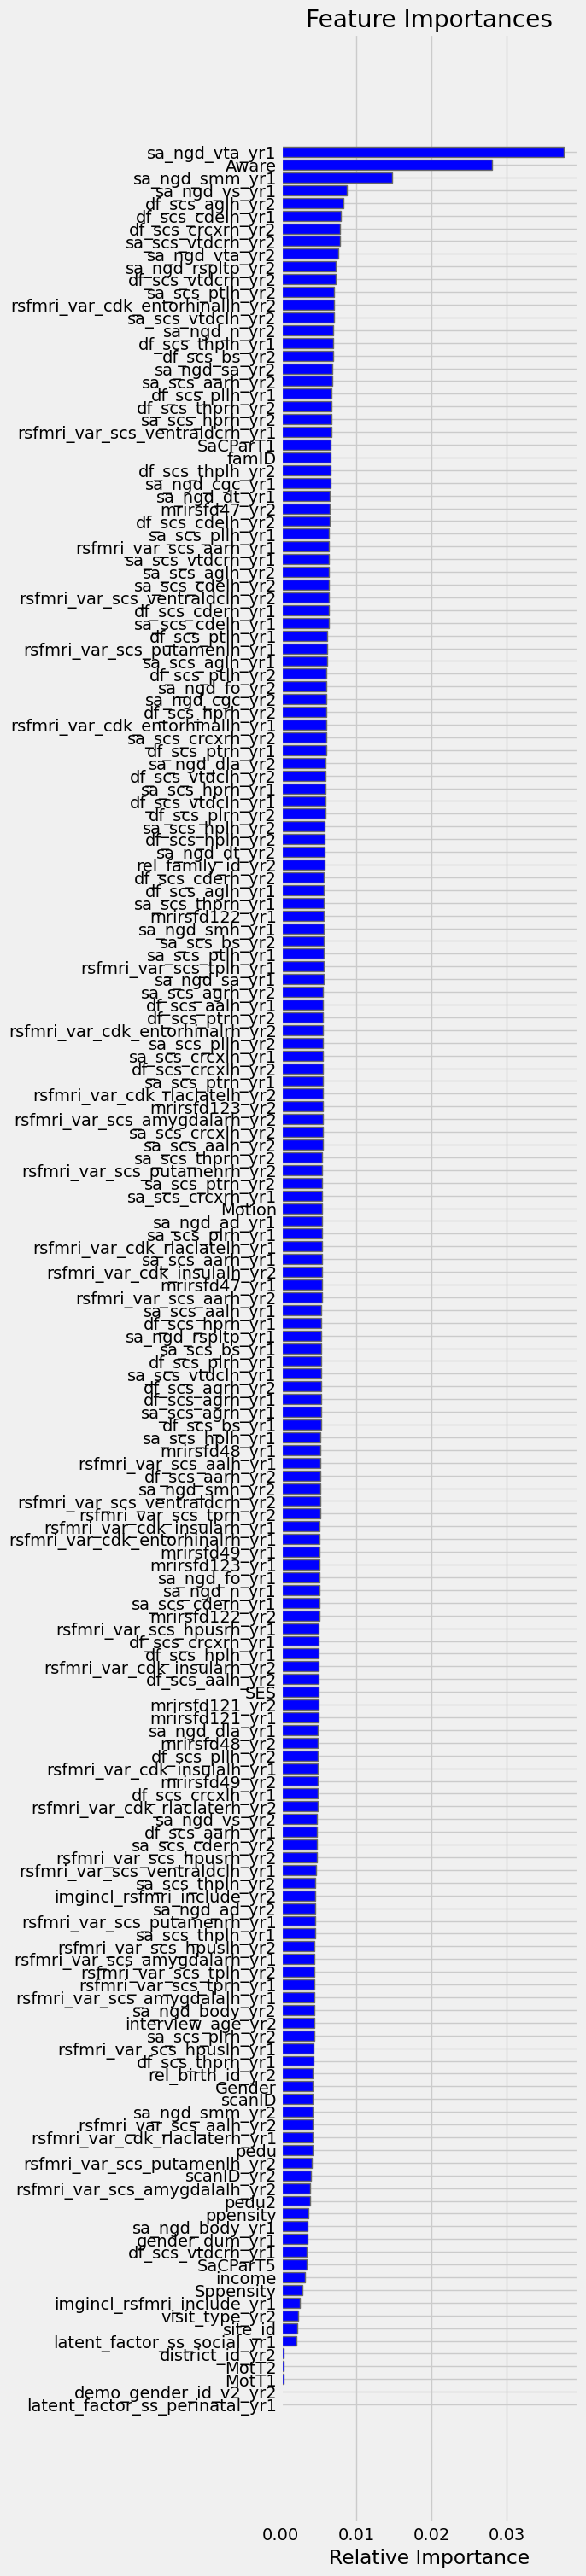

In [30]:
plt.figure(figsize=(4, 36))
features = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

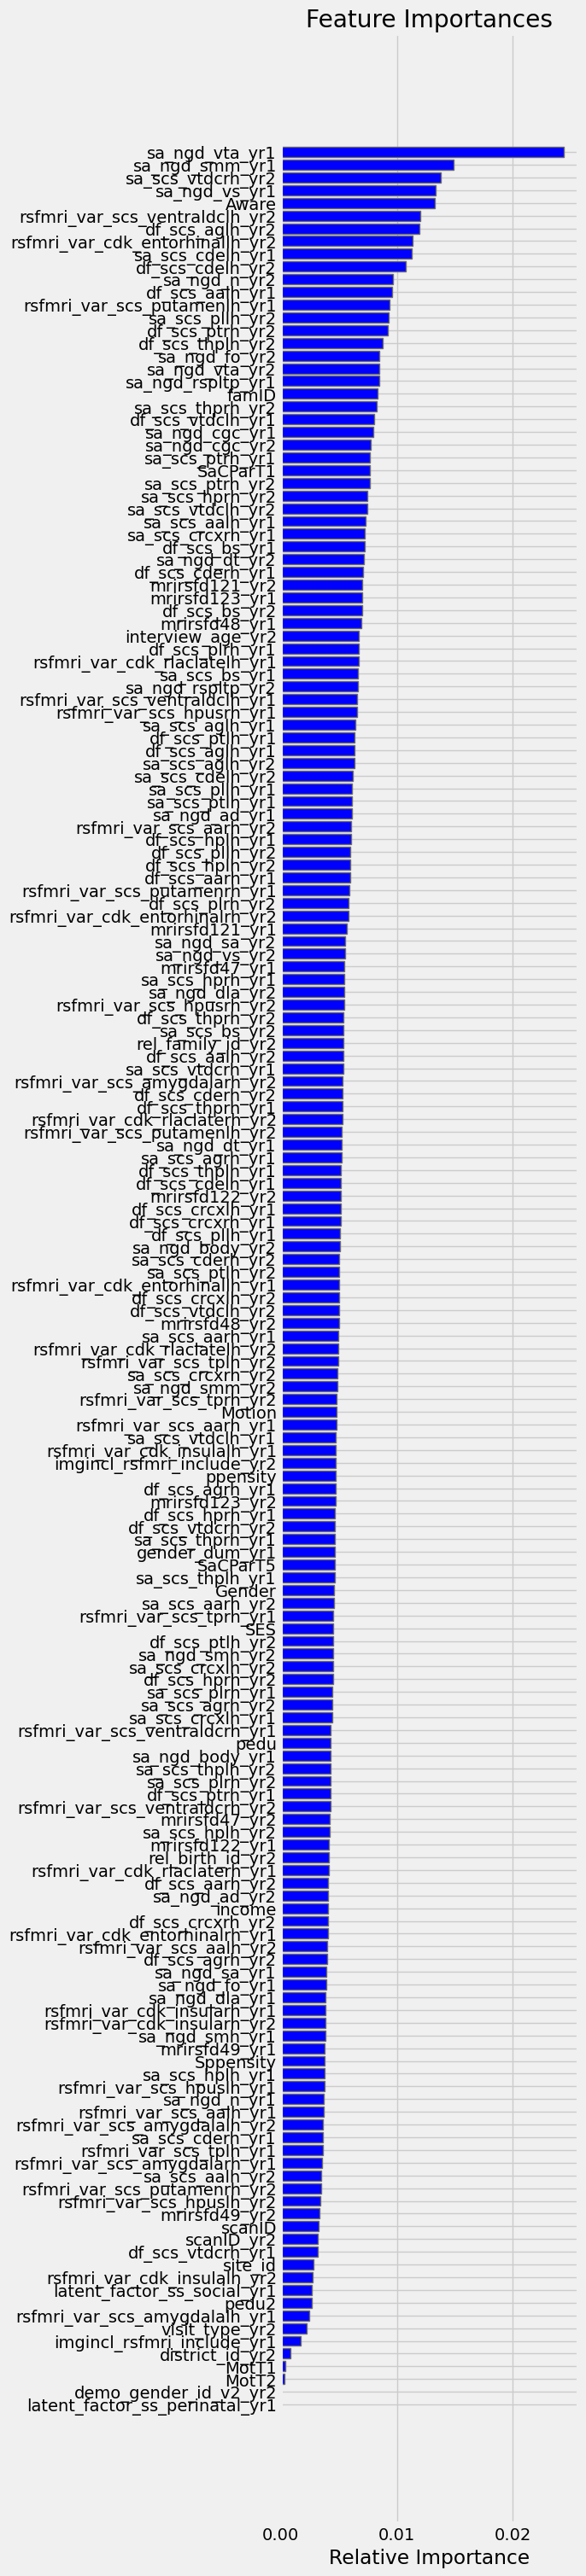

In [25]:
plt.figure(figsize=(4, 36))
features = rs_train.select_dtypes(exclude=[object]).drop(cdrop, axis=1).columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()